In [1]:
#makes sure to reload our modules on each execution

%load_ext autoreload 
%autoreload 1
%aimport gans, preprocessing, sourceSeparation

import concurrent.futures
import matplotlib.pyplot as plt
import torch
import pickle
import numpy as np

In [2]:
# constants

batchSize = 64
noiseDim = 200
includedSimulations=13



In [90]:
# generates preprocessed datasets for our models and saves them to disk
trainSpikesLoader, valSpikesLoader, testSpikesLoader, trainBgLoader, valBgLoader, testBgLoader = preprocessing.gen_loaders( 
    batchSize,
    includedSimulations
)

pickle.dump(trainSpikesLoader, open("../data/trainSpikesLoader.pickle", "wb"))
pickle.dump(valSpikesLoader, open("../data/valSpikesLoader.pickle", "wb"))
pickle.dump(testSpikesLoader, open("../data/testSpikesLoader.pickle", "wb"))
pickle.dump(trainBgLoader, open("../data/trainBgLoader.pickle", "wb"))
pickle.dump(valBgLoader, open("../data/valBgLoader.pickle", "wb"))
pickle.dump(testBgLoader, open("../data/testBgLoader.pickle", "wb"))

In [3]:
#loads preprocessed datasets from disk

trainSpikesLoader = pickle.load(open("../data/trainSpikesLoader.pickle", "rb"))
valSpikesLoader = pickle.load(open("../data/valSpikesLoader.pickle", "rb"))
testSpikesLoader = pickle.load(open("../data/testSpikesLoader.pickle", "rb"))
trainBgLoader = pickle.load(open("../data/trainBgLoader.pickle", "rb"))
valBgLoader = pickle.load(open("../data/valBgLoader.pickle", "rb"))
testBgLoader = pickle.load(open("../data/testBgLoader.pickle", "rb"))

Spike generator training


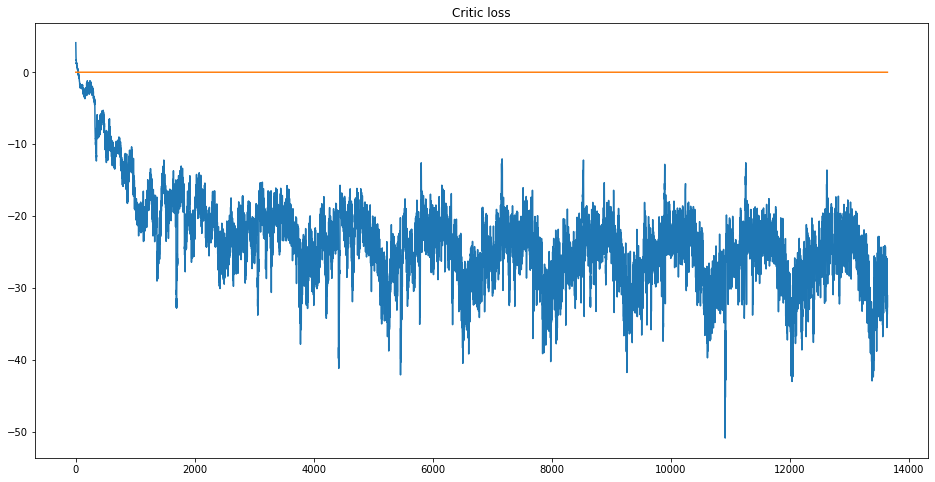

Critic loss -32.64806365966797

Epoch 9

Generated example:


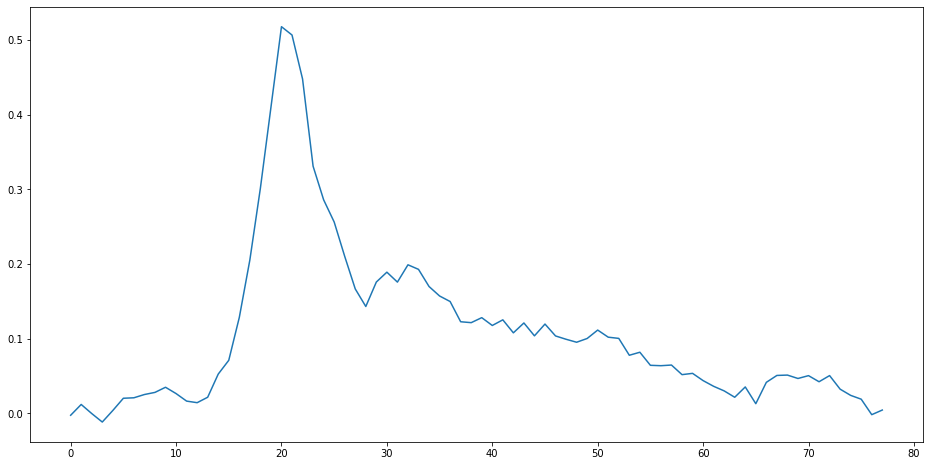

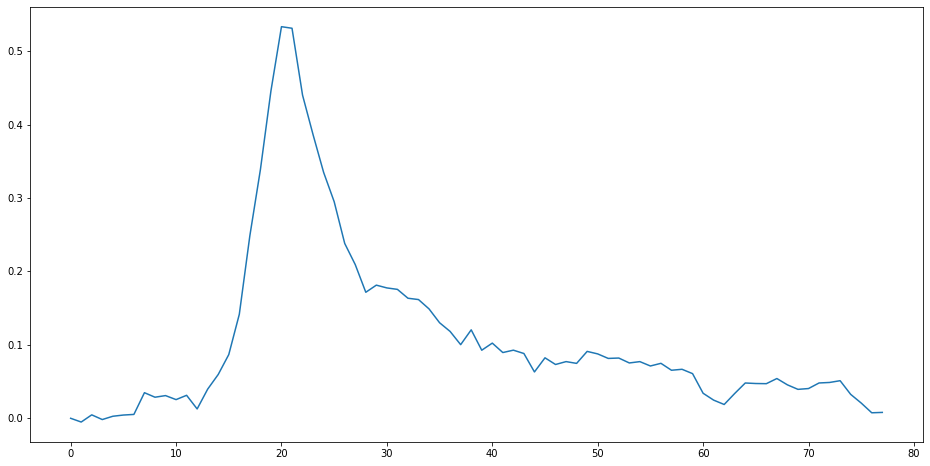

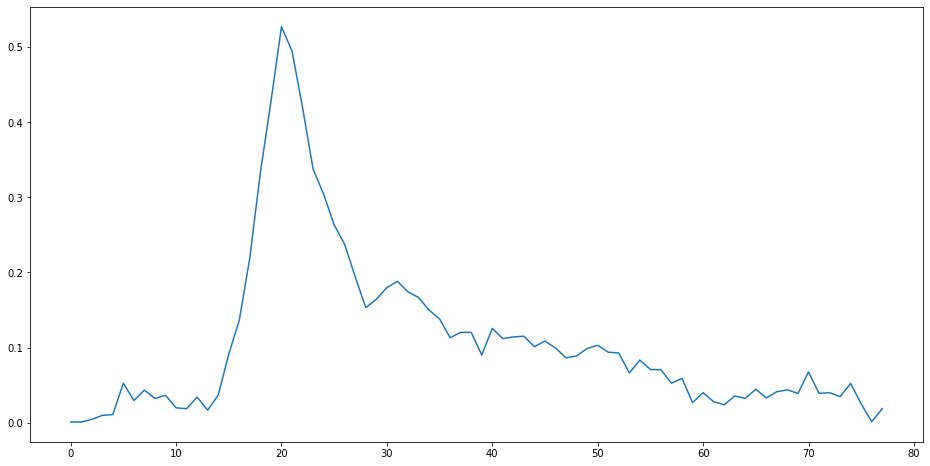

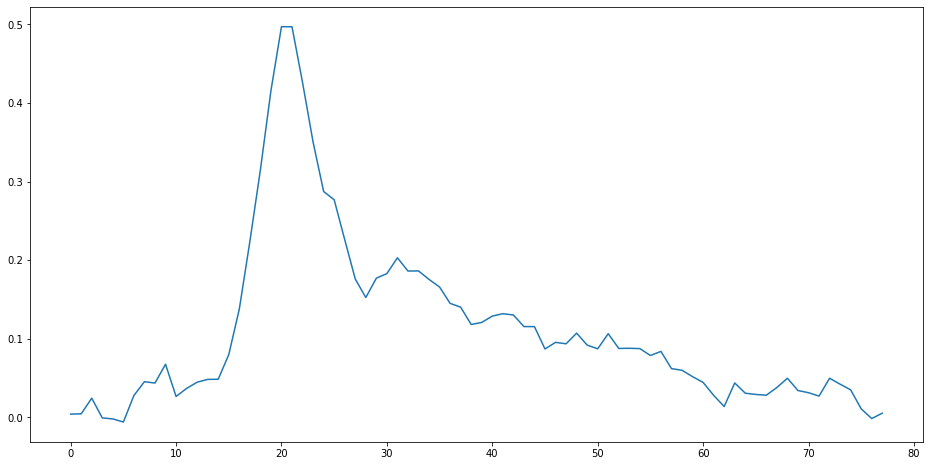

In [39]:
# declares and trains the gan for spikes 

gen1 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
critic1 = gans.CriticWgan(inputSize=80, hiddenSize=40)

print("Spike generator training")

gans.wgan_adversarial_trainer( 
    train_loader = trainSpikesLoader,
    generator = gen1, 
    critic = critic1, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 10,
)

Background generator training


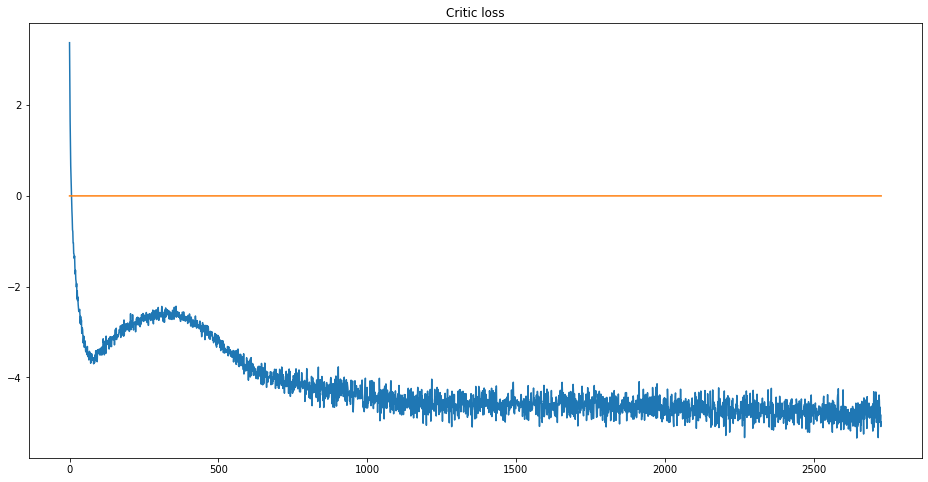

Critic loss -4.983720779418945

Epoch 1

Generated example:


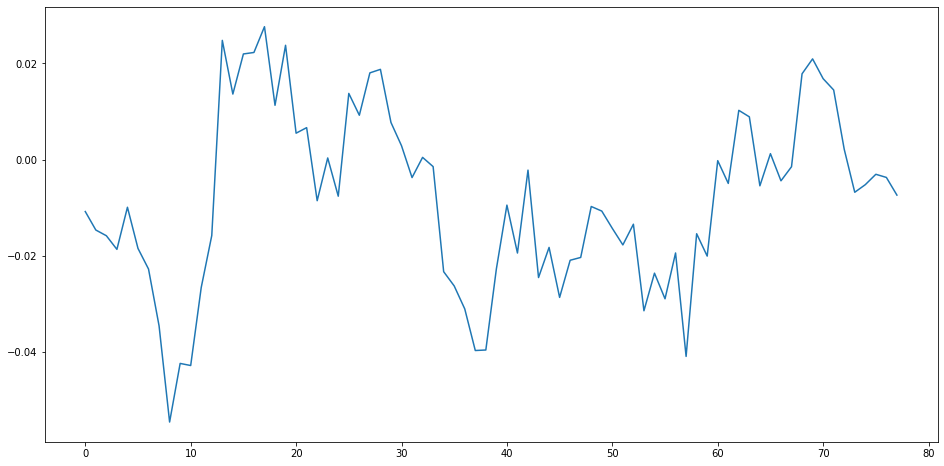

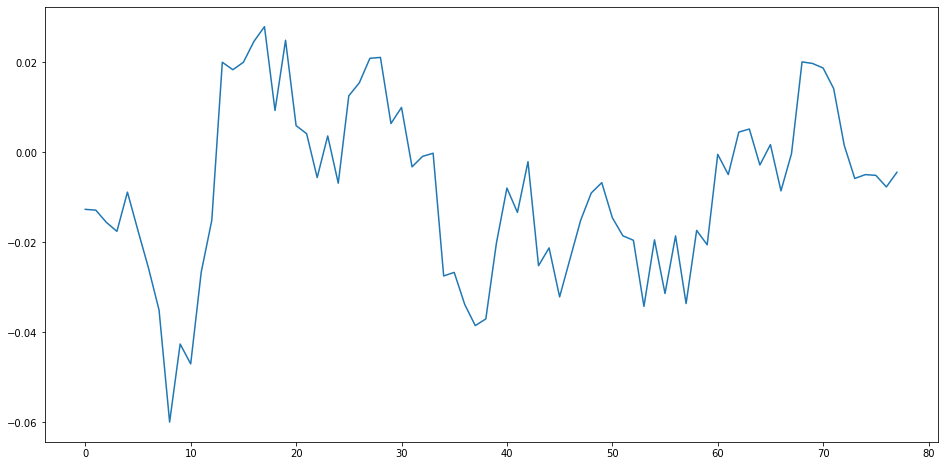

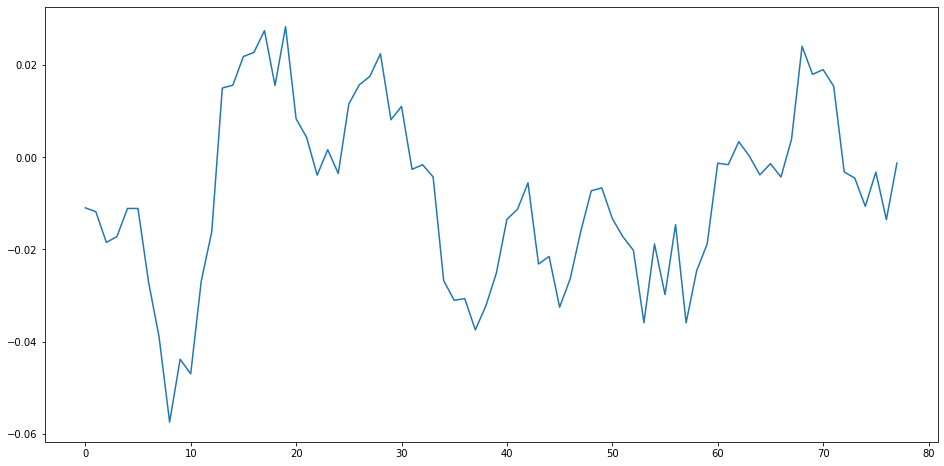

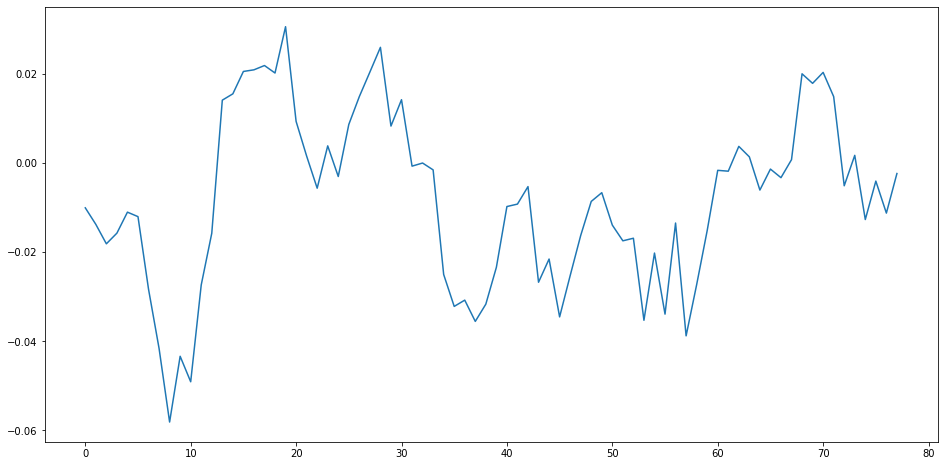

In [6]:
# declares and trains the gan for hash

gen2 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=10, outputSize=80)
critic2 = gans.CriticWgan(inputSize=80, hiddenSize=40)
print("Background generator training")

gans.wgan_adversarial_trainer( 
    train_loader = trainBgLoader,
    generator = gen2, 
    critic = critic2, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 2,
)

torch.Size([10907, 80])


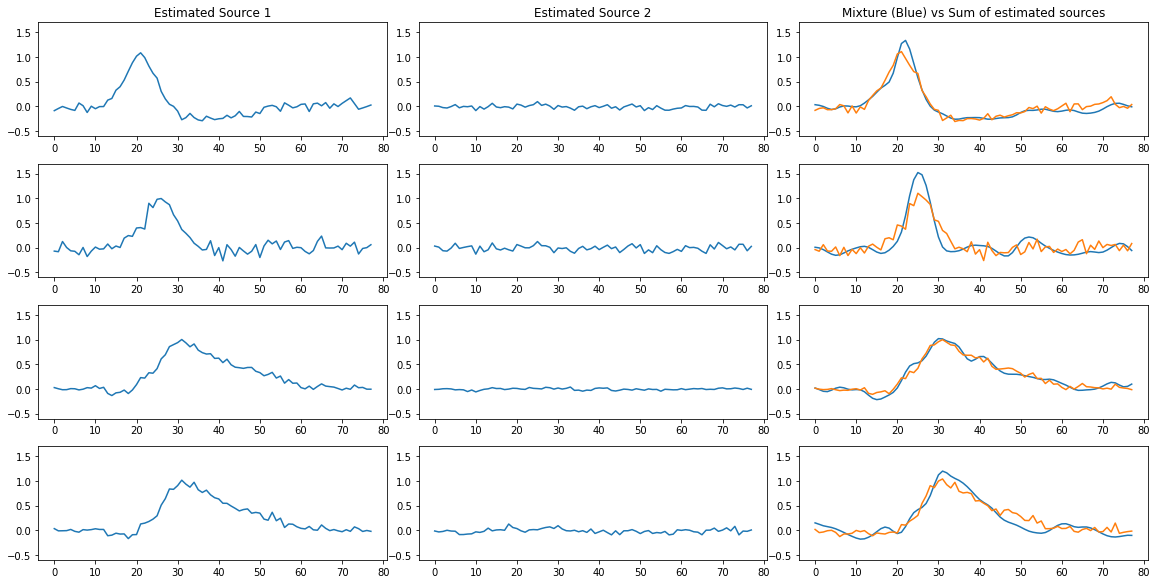

In [40]:
# separates the spike samples

(cleanextractedSpikesValidationSpikes,cleanextractedNoisesValidationSpikes) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=valSpikesLoader,
    epochs=3000
)

torch.Size([10907, 80])


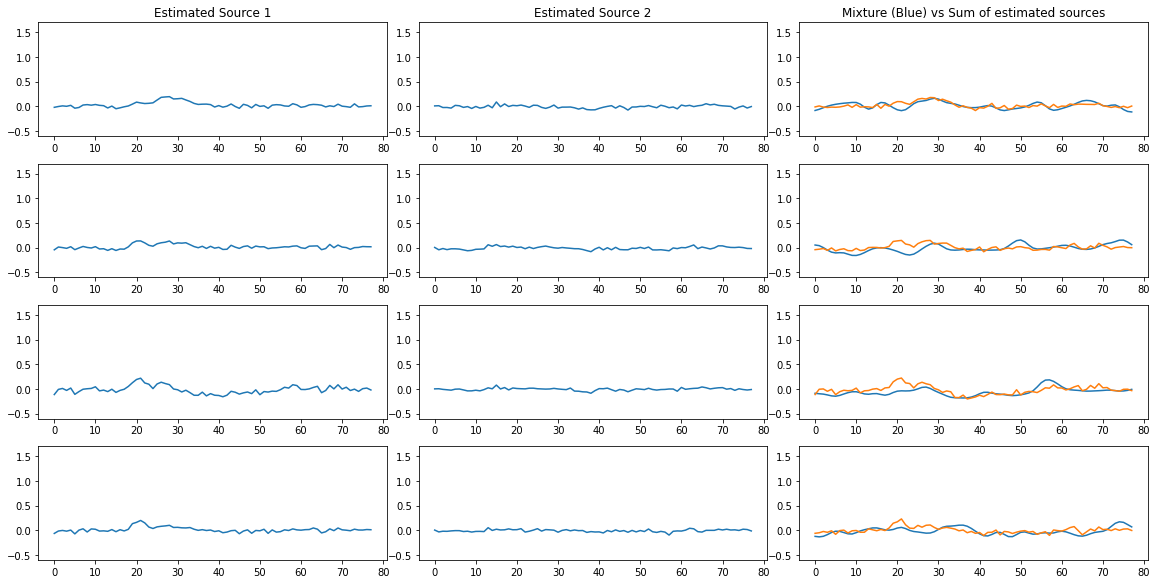

In [41]:
# separates the noise samples

(cleanextractedSpikesValidationBg,cleanextractedNoisesValidationBg) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=valBgLoader,
    epochs=3000
)

In [42]:
valExtractedSpikes = np.concatenate((cleanextractedSpikesValidationSpikes,cleanextractedSpikesValidationBg),axis=0)
vallabel = np.concatenate(([1 for _ in cleanextractedSpikesValidationSpikes],[0 for _ in cleanextractedSpikesValidationBg]),axis=0)

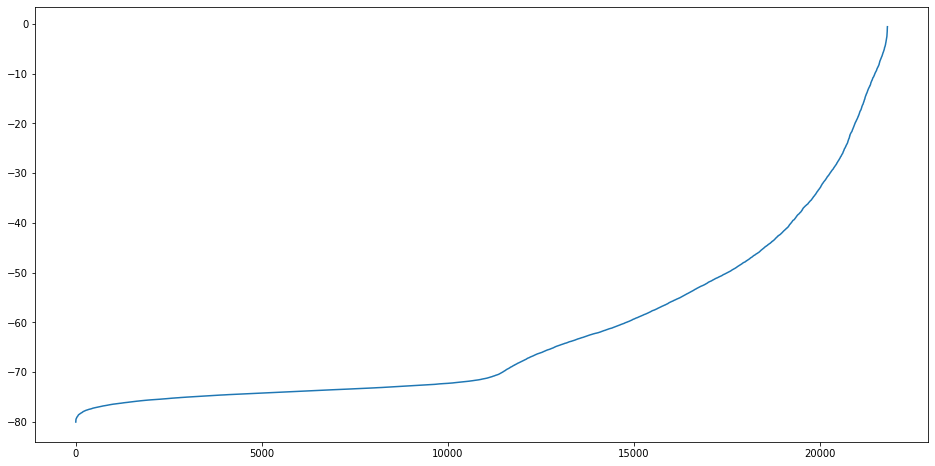

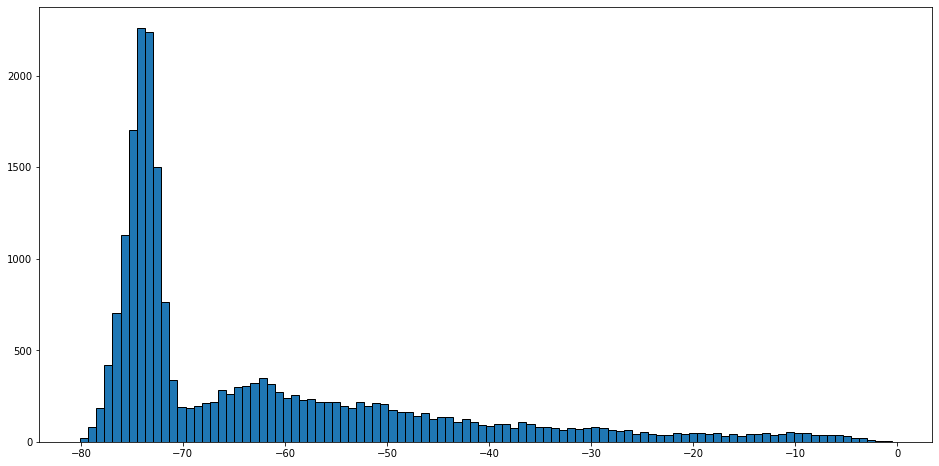

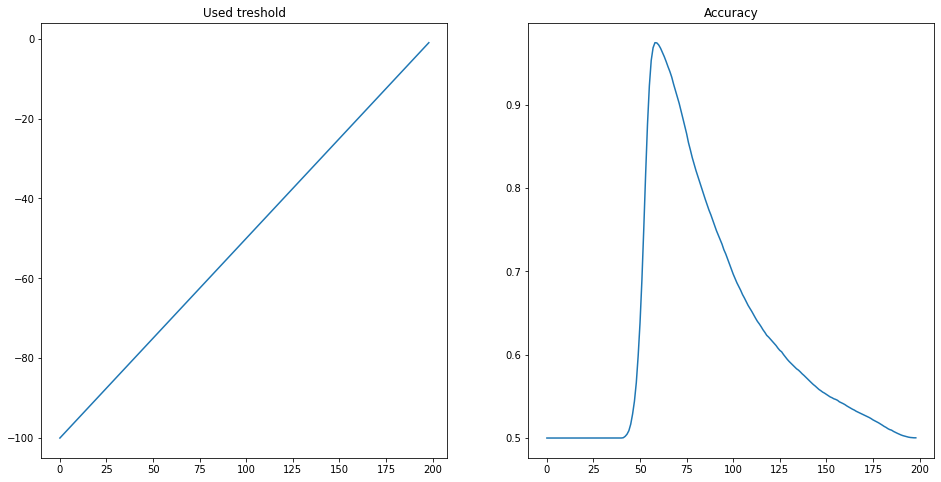

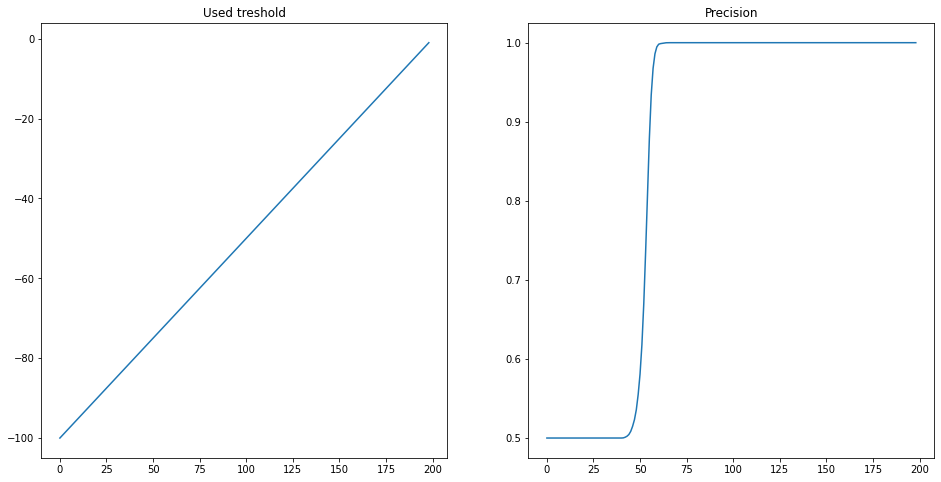

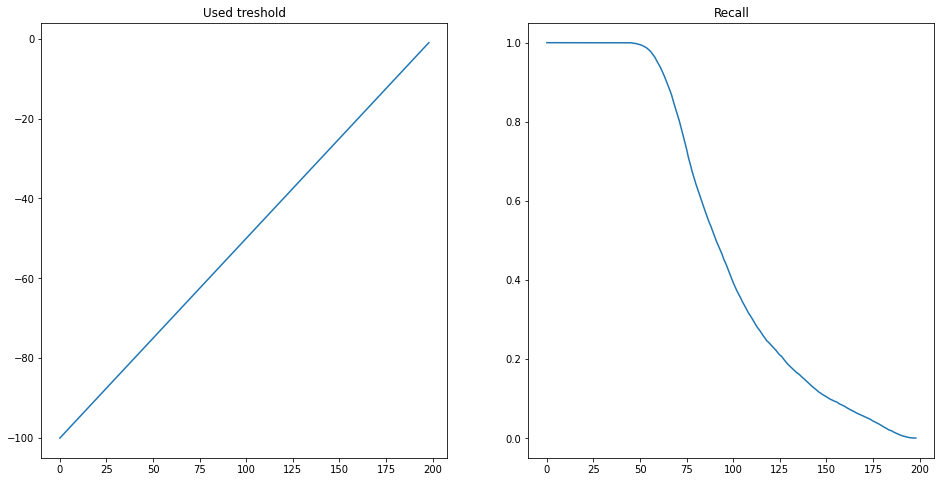

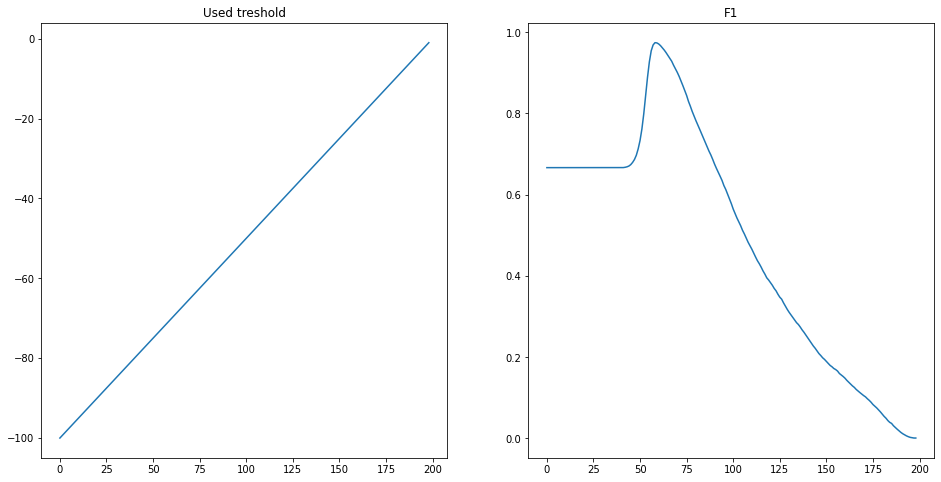

Threshold for best F1: -71.0
Threshold: -71.0
Precision: 0.9859181374389786
Recall: 0.9628678830109104
F1: 0.9742566909411383
Accuracy: 0.9745576235445127


In [54]:
sourceSeparation.interpretSeparation(valExtractedSpikes, critic1, vallabel,method="critic")

torch.Size([10901, 80])


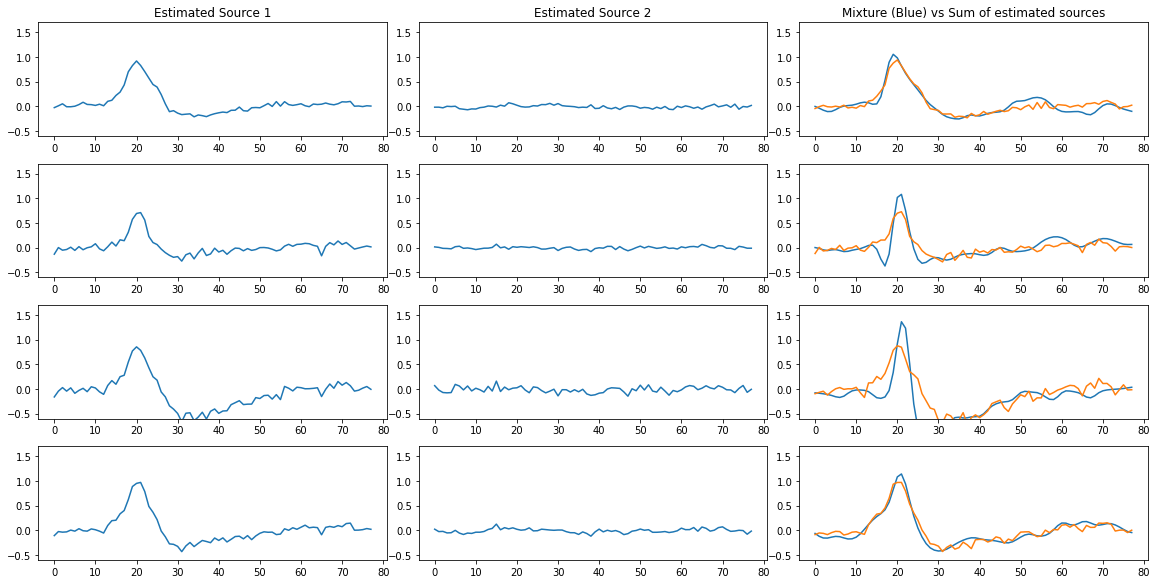

In [44]:
# separates the spike samples

(cleanextractedSpikesTestSpikes,cleanextractedNoisesTestSpikes) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=testSpikesLoader,
    epochs=2000
)

torch.Size([10901, 80])


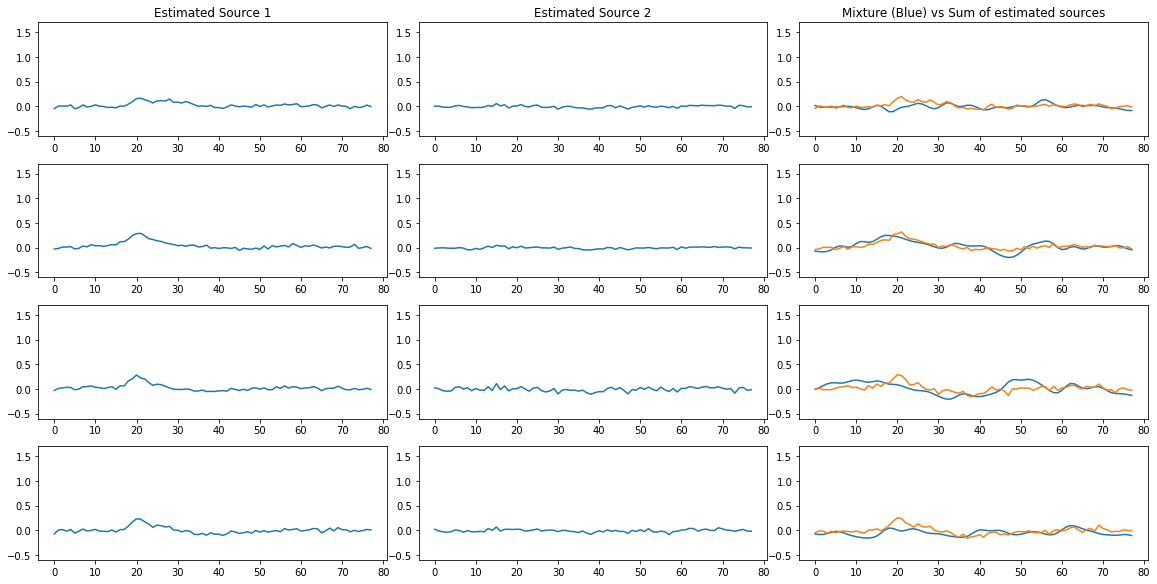

In [45]:
# separates the noise samples

(cleanextractedSpikesTestBg,cleanextractedNoisesTestBg) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=testBgLoader,
    epochs=2000
)

In [46]:
testExtractedSpikes = np.concatenate((cleanextractedSpikesTestSpikes,cleanextractedSpikesTestBg),axis=0)
testlabel = np.concatenate(([1 for _ in cleanextractedSpikesTestSpikes],[0 for _ in cleanextractedSpikesTestBg]),axis=0)

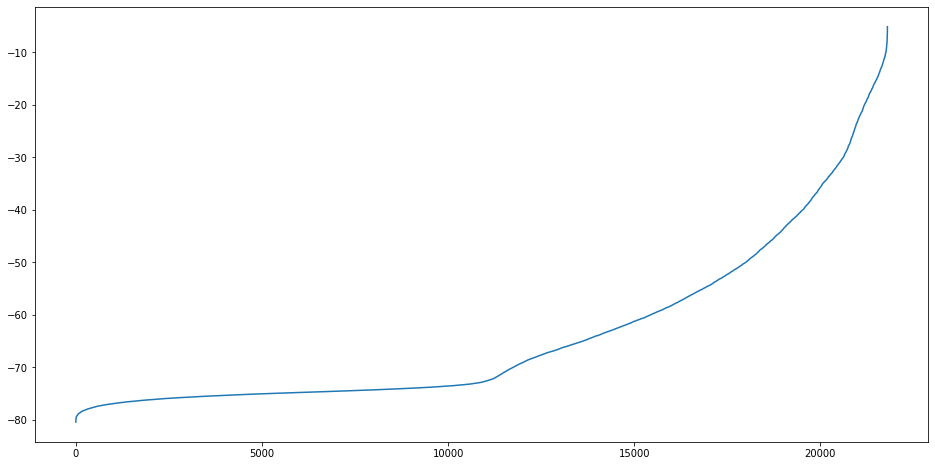

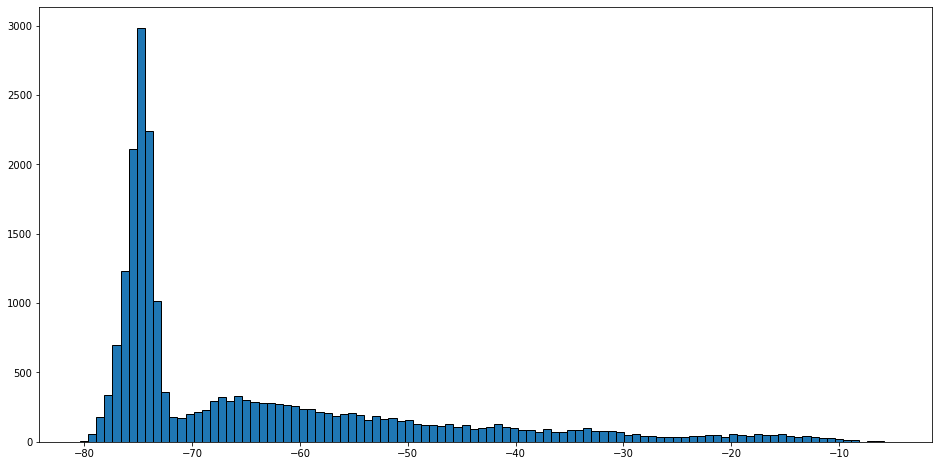

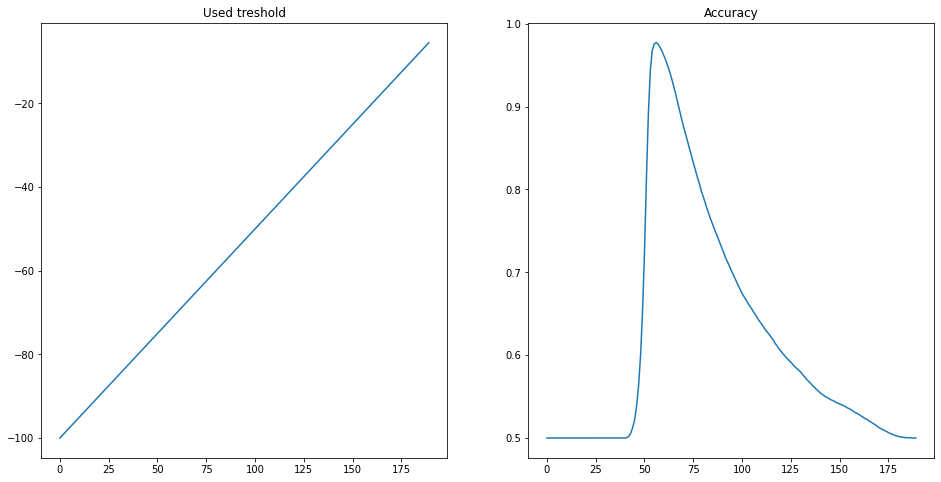

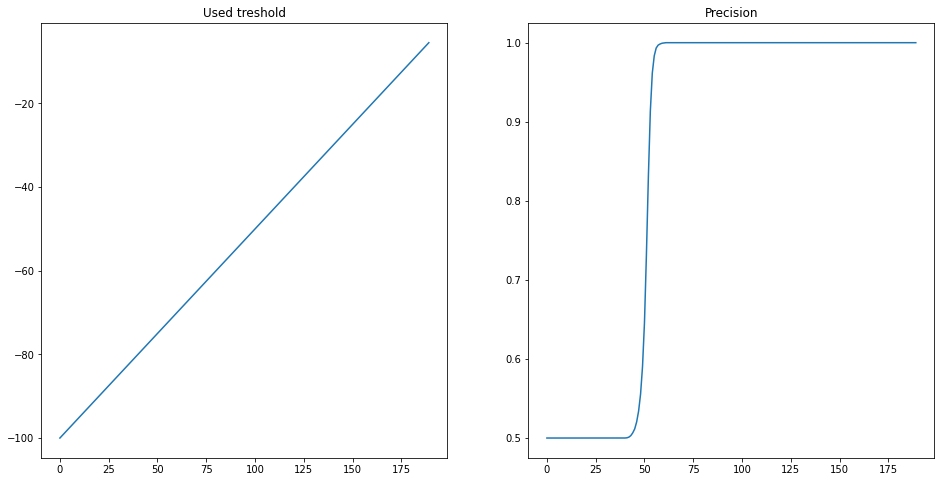

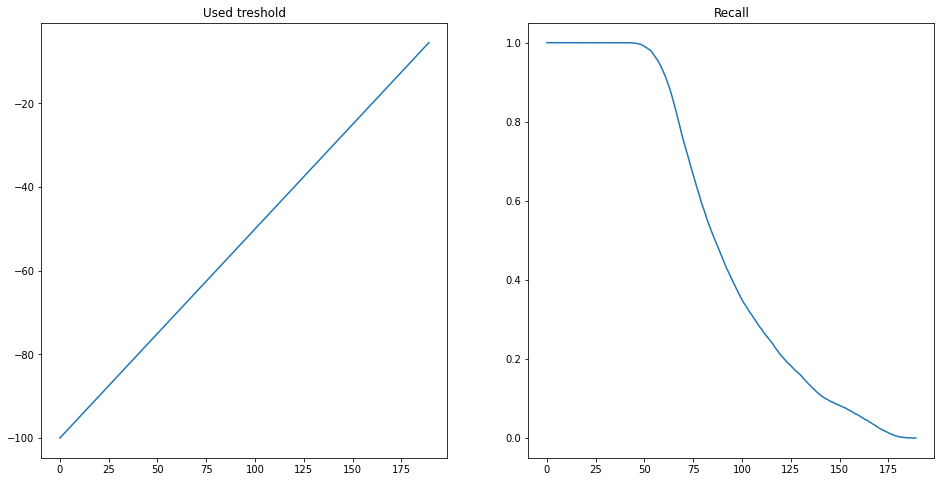

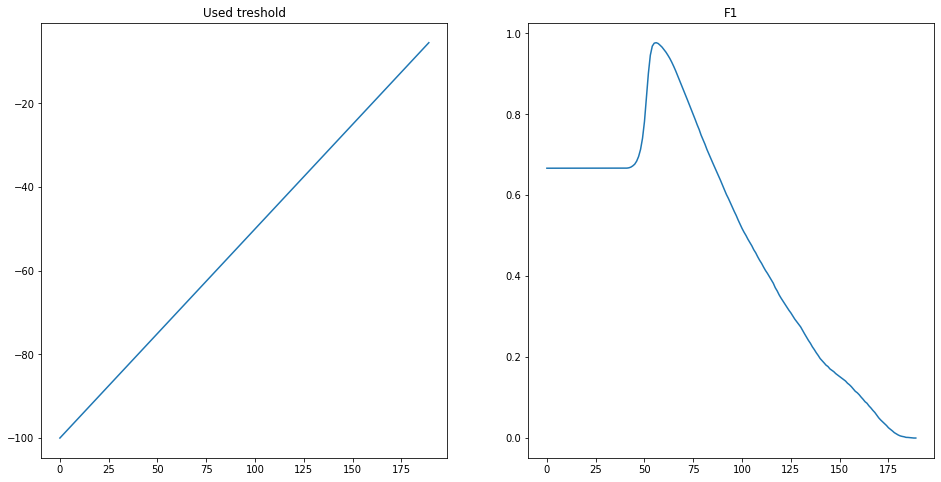

Threshold for best F1: -72.0
Threshold: 1.35


ZeroDivisionError: division by zero

In [53]:
sourceSeparation.interpretSeparation(testExtractedSpikes, critic1, testlabel,test=True, testThreshold=1.35,method="critic")